# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.



### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [73]:
# path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# path = '/content/drive/MyDrive/project/'

#### 3) 데이터 읽어오기

In [76]:
# file1 = 'open_data.csv'
# file2 = 'weather.csv'

In [77]:
data1 = pd.read_csv('/content/drive/MyDrive/KT AIVLE/미니프로젝트 6차_3~4일차_실습자료/open_data.csv')
data2 = pd.read_csv('/content/drive/MyDrive/KT AIVLE/미니프로젝트 6차_3~4일차_실습자료/weather.csv')

#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [78]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [79]:
data1.head()

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


In [80]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


In [81]:
data1.head()

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [82]:
data1.rename(columns={'기준일' : 'Date', '차량운행':'count', '접수건' : 'submission', '탑승건':'boarding', '평균대기시간' : 'mean_time', '평균요금':'mean_fare', '평균승차거리':'mean_dis'}, inplace=True)

## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [83]:
df1 = data1.copy()

In [85]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [86]:
df1['day'] = df1['Date'].dt.day
df1['weekday'] = df1['Date'].dt.weekday
df1['week'] = df1['Date'].dt.isocalendar().week
df1['month'] = df1['Date'].dt.month
df1['year'] = df1['Date'].dt.year

In [87]:
df1.head()

,Date,count,submission,boarding,mean_time,mean_fare,mean_dis,day,weekday,week,month,year
0,2015-01-01,213,1023,924,23.2,2427,10764,1,3,1,1,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,2,4,1,1,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,3,5,1,1,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,4,6,1,1,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,5,0,2,1,2015


### (2) 일별

* 차량 운행수

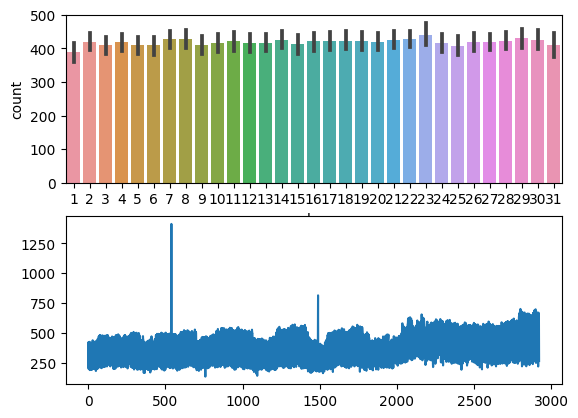

In [88]:
plt.subplot(2,1,1)
sns.barplot(data=df1, x='day', y='count')
plt.subplot(2,1,2)
plt.plot('count',data=df1)
plt.show()

In [89]:
df1.loc[df1['count']>800]

,Date,count,submission,boarding,mean_time,mean_fare,mean_dis,day,weekday,week,month,year
539,2016-06-23,1413,5111,4378,41.0,2268,9219,23,3,25,6,2016
1489,2019-01-29,814,4943,3758,63.9,2269,8722,29,1,5,1,2019


* 접수건, 탑승건

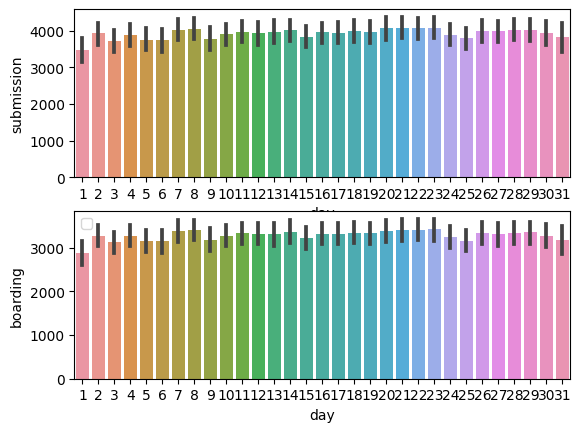

In [90]:
plt.subplot(2,1,1)
sns.barplot(data=df1, x='day', y='submission')
plt.subplot(2,1,2)
sns.barplot(data=df1, x='day', y='boarding')
plt.legend()
plt.show()

* 대기시간

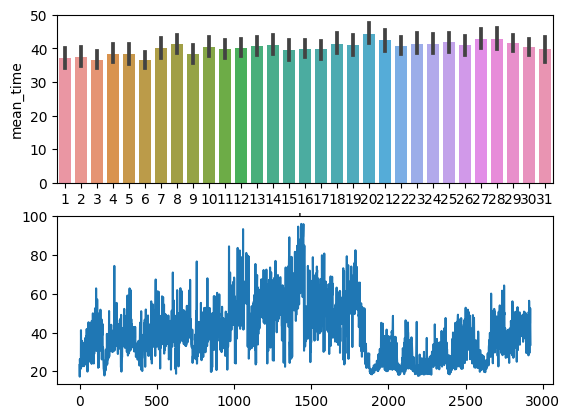

In [91]:
plt.subplot(2,1,1)
sns.barplot(data=df1, x='day', y='mean_time')
plt.subplot(2,1,2)
plt.plot('mean_time',data=df1)
plt.show()

In [92]:
df1.loc[df1['mean_time']>90]

,Date,count,submission,boarding,mean_time,mean_fare,mean_dis,day,weekday,week,month,year
1059,2017-11-25,238,2268,1432,93.4,2507,10915,25,5,47,11,2017
1416,2018-11-17,205,2088,1442,94.7,2475,10561,17,5,46,11,2018
1436,2018-12-07,411,4713,3229,96.1,2258,8795,7,4,49,12,2018
1437,2018-12-08,215,2101,1428,90.2,2554,11563,8,5,49,12,2018
1443,2018-12-14,413,4821,3465,91.8,2263,8815,14,4,50,12,2018
1449,2018-12-20,406,4856,3509,92.4,2265,8761,20,3,51,12,2018
1450,2018-12-21,406,4835,3435,96.0,2283,8933,21,4,51,12,2018


* 운임

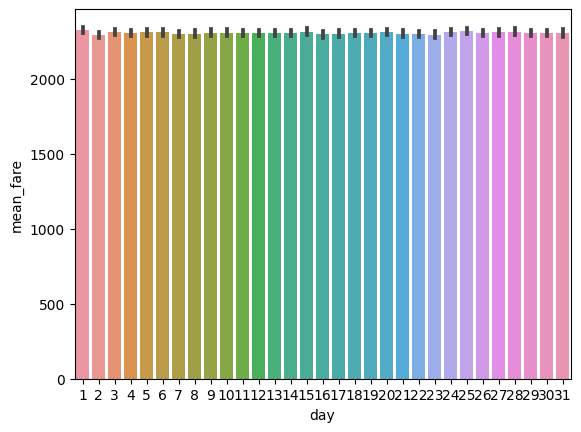

In [93]:
sns.barplot(data=df1, x='day', y='mean_fare')
plt.show()

* 이동거리

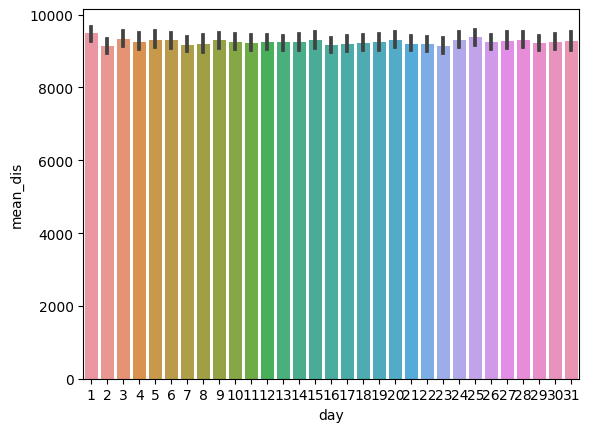

In [94]:
sns.barplot(data=df1, x='day', y='mean_dis')
plt.show()

### (3) 요일별

* 차량 운행수

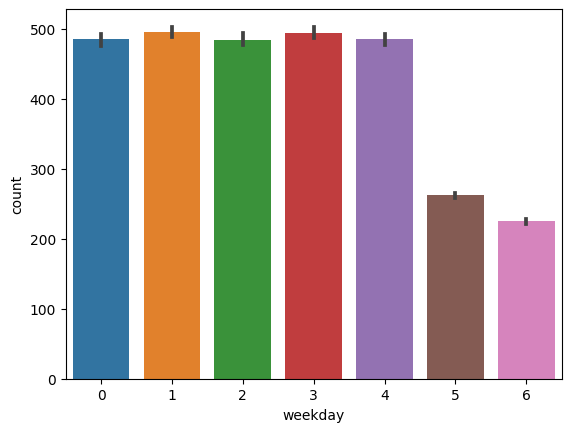

In [95]:
sns.barplot(data=df1, x='weekday', y='count')
plt.show()

* 접수건, 탑승건

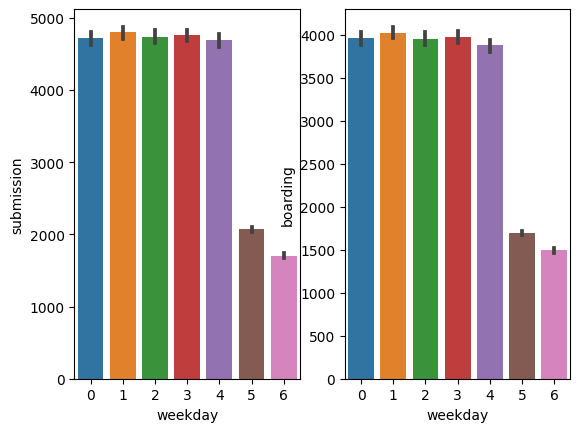

In [97]:
plt.subplot(1,2,1)
sns.barplot(data=df1, x='weekday', y='submission')
plt.subplot(1,2,2)
sns.barplot(data=df1, x='weekday', y='boarding')
plt.show()

* 대기시간

<Axes: xlabel='weekday', ylabel='mean_time'>

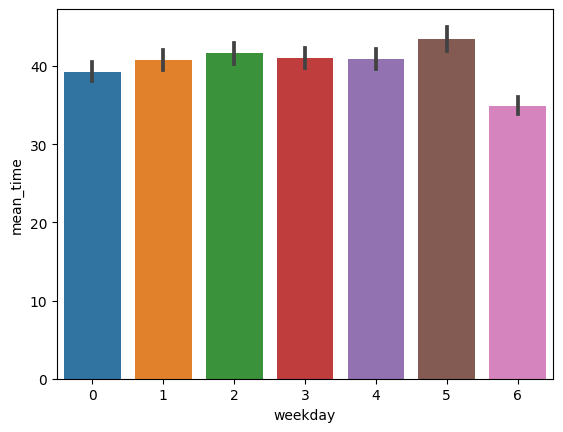

In [98]:
sns.barplot(data=df1, x='weekday', y='mean_time')

* 운임

<Axes: xlabel='weekday', ylabel='mean_fare'>

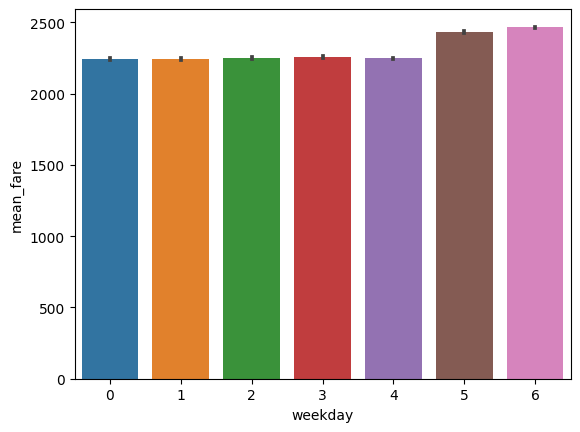

In [99]:
sns.barplot(data=df1, x='weekday', y='mean_fare')

* 이동거리

<Axes: xlabel='weekday', ylabel='mean_dis'>

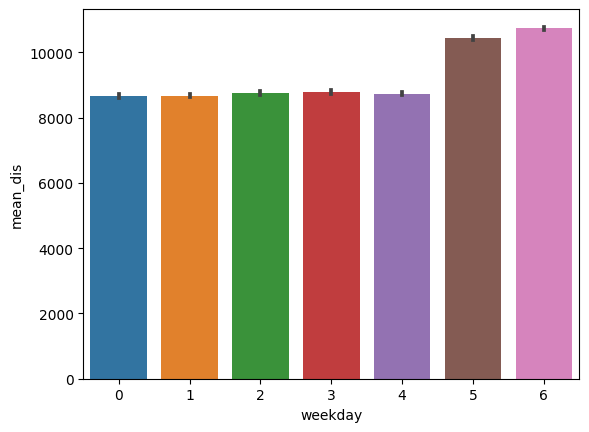

In [100]:
sns.barplot(data=df1, x='weekday', y='mean_dis')

### (4) 월별

* 차량 운행수

<Axes: xlabel='month', ylabel='count'>

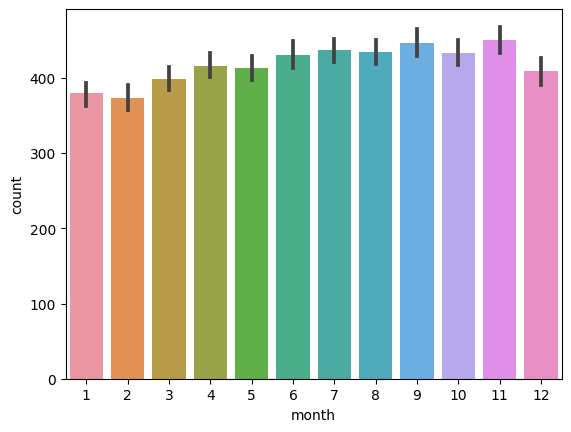

In [101]:
sns.barplot(data=df1, x='month', y='count')

* 접수건, 탑승건

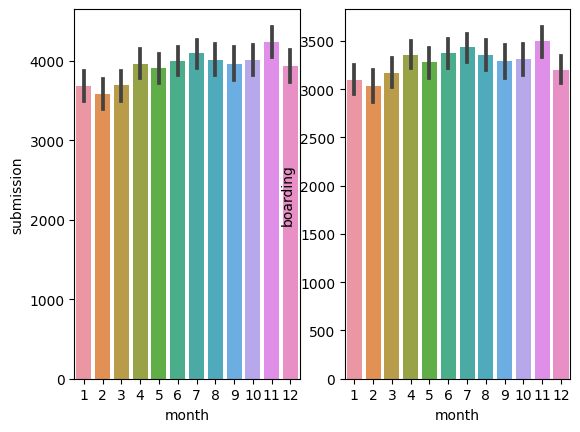

In [102]:
plt.subplot(1,2,1)
sns.barplot(data=df1, x='month', y='submission')
plt.subplot(1,2,2)
sns.barplot(data=df1, x='month', y='boarding')
plt.show()

* 대기시간

<Axes: xlabel='month', ylabel='mean_time'>

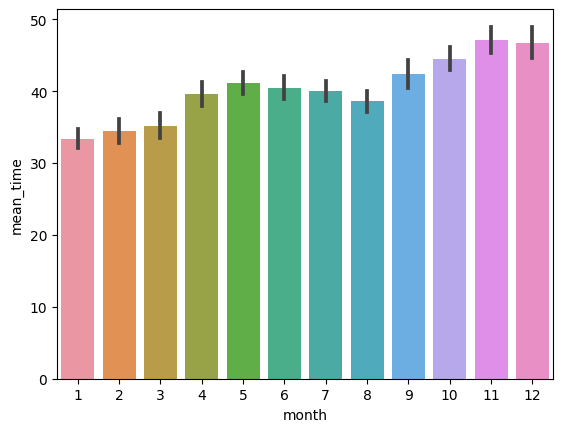

In [103]:
sns.barplot(data=df1, x='month', y='mean_time')

* 운임

<Axes: xlabel='month', ylabel='mean_fare'>

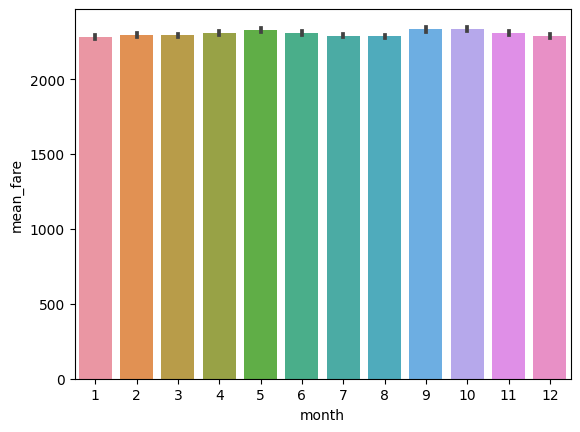

In [105]:
sns.barplot(data=df1, x='month', y='mean_fare')

* 이동거리

<Axes: xlabel='month', ylabel='mean_dis'>

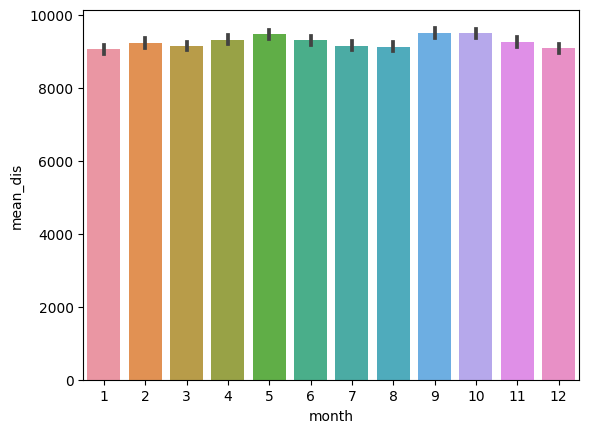

In [106]:
sns.barplot(data=df1, x='month', y='mean_dis')

### (5) 연도별

* 차량 운행수

<Axes: xlabel='year', ylabel='count'>

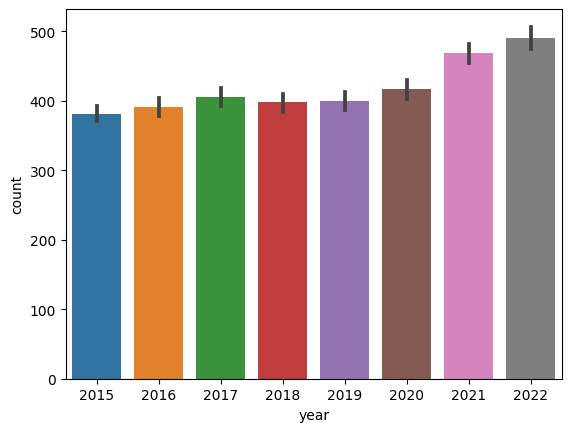

In [107]:
sns.barplot(data=df1, x='year', y='count')

* 대기시간

<Axes: xlabel='year', ylabel='mean_time'>

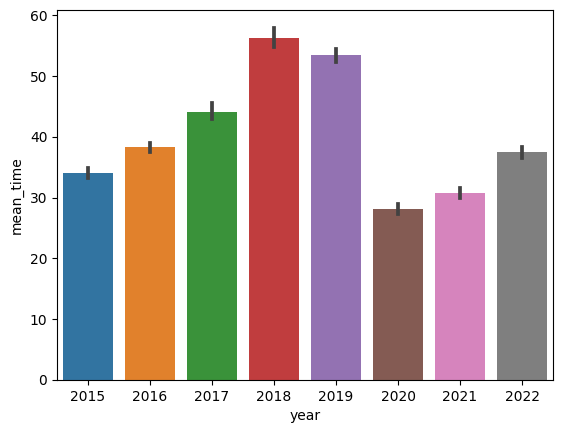

In [108]:
sns.barplot(data=df1, x='year', y='mean_time')

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [109]:
target = 'mean_time'

### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [110]:
data = pd.merge(data1, data2, on = 'Date')
data.head()

,Date,count,submission,boarding,mean_time,mean_fare,mean_dis,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,23.2,2427,10764,-4.3,-9.8,0.0,52.0,33.0,9.79
1,2015-01-02,420,3158,2839,17.2,2216,8611,-2.0,-8.9,0.0,63.0,28.0,9.07
2,2015-01-03,209,1648,1514,26.2,2377,10198,2.4,-9.2,0.0,73.0,37.0,8.66
3,2015-01-04,196,1646,1526,24.5,2431,10955,8.2,0.2,0.0,89.0,58.0,5.32
4,2015-01-05,421,4250,3730,26.2,2214,8663,7.9,-0.9,0.0,95.0,52.0,6.48


In [111]:
data[['temp_max', 'temp_min', 'rain(mm)', 'humidity_max(%)', 'humidity_min(%)',	'sunshine(MJ/m2)']] = data[['temp_max', 'temp_min', 'rain(mm)', 'humidity_max(%)', 'humidity_min(%)',	'sunshine(MJ/m2)']].shift()

In [112]:
data.head()

,Date,count,submission,boarding,mean_time,mean_fare,mean_dis,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,23.2,2427,10764,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,420,3158,2839,17.2,2216,8611,-4.3,-9.8,0.0,52.0,33.0,9.79
2,2015-01-03,209,1648,1514,26.2,2377,10198,-2.0,-8.9,0.0,63.0,28.0,9.07
3,2015-01-04,196,1646,1526,24.5,2431,10955,2.4,-9.2,0.0,73.0,37.0,8.66
4,2015-01-05,421,4250,3730,26.2,2214,8663,8.2,0.2,0.0,89.0,58.0,5.32


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2922 non-null   object 
 1   count            2922 non-null   int64  
 2   submission       2922 non-null   int64  
 3   boarding         2922 non-null   int64  
 4   mean_time        2922 non-null   float64
 5   mean_fare        2922 non-null   int64  
 6   mean_dis         2922 non-null   int64  
 7   temp_max         2921 non-null   float64
 8   temp_min         2921 non-null   float64
 9   rain(mm)         2921 non-null   float64
 10  humidity_max(%)  2921 non-null   float64
 11  humidity_min(%)  2921 non-null   float64
 12  sunshine(MJ/m2)  2921 non-null   float64
dtypes: float64(7), int64(5), object(1)
memory usage: 319.6+ KB


In [114]:
data['Date'] = pd.to_datetime(data['Date'])

In [123]:
data['weekday'] = pd.Categorical(data['Date'].dt.weekday)
data['month'] = pd.Categorical(data['Date'].dt.month)
data['year'] = pd.Categorical(data['Date'].dt.year)

In [124]:
def get_season(month):
    if month >= 3 and month <= 5:
        return 'spr'
    elif month >= 6 and month <= 8:
        return 'sum'
    elif month >= 9 and month <= 11:
        return 'fal'
    else:
        return 'win'

data['season'] = pd.Categorical(data['month'].apply(get_season))

#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [121]:
!pip install workalendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.5 MB/s eta 0:00:00


* 간단 사용법

In [132]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2015))

,0,1
0,2015-01-01,New year
1,2015-02-18,Korean New Year's Day
2,2015-02-19,Korean New Year's Day
3,2015-02-20,Korean New Year's Day
4,2015-03-01,Independence Day
5,2015-05-05,Children's Day
6,2015-05-25,Buddha's Birthday
7,2015-06-06,Memorial Day
8,2015-08-15,Liberation Day
9,2015-09-26,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [128]:
holidays = pd.concat([pd.DataFrame(cal.holidays(2015)), pd.DataFrame(cal.holidays(2016)), pd.DataFrame(cal.holidays(2017)), pd.DataFrame(cal.holidays(2018)), pd.DataFrame(cal.holidays(2019)), pd.DataFrame(cal.holidays(2020)),pd.DataFrame(cal.holidays(2021)), pd.DataFrame(cal.holidays(2022))], ignore_index=True)

In [130]:
holidays.rename(columns={0:'Date', 1:'holidays'}, inplace=True)

In [131]:
holidays['Date'] = pd.to_datetime(holidays['Date'])

* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [134]:
data = pd.merge(data, holidays, on='Date', how='outer')

In [136]:
data['holidays'].fillna(0, inplace=True)

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [151]:
data['mean_time_rm'] = data['mean_time'].rolling(7).mean()

#### 4) 탑승률

In [153]:
# 탑승률 = boarding / submission * 100
data['rates'] = data['boarding'] / data['submission'] * 100

## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [156]:
joblib.dump(data, 'data1.pkl')

['data1.pkl']